# Milestone #3 #


***Basic Information***

CS-109a

***Team-members:***

Timur Zambalayev and Joshua Coffie

***Submitted on November 5, 2016***

# Background - Project Summary


Using a movie-ratings based dataset, we will analyze the data, build a baseline model to explain the data, and implement a recommendation technique for future use.

Throughout this process,  we'll explore:

★ What are the features that makes movies popular?

★ Can we predict sentiments of reviews?

★ Can we predict user preferences?


<b>Data Exploration and Cleaning:</b>

We will perform the following exploration steps:

❖ Decide on a suitable database to store the data [Complete]

❖ Decide on a computing resource to process the data (AWS, Microsoft Azure, personal computer).

❖ Perform Feature Extraction/Selection (where can you get other features?)

❖ Remove/Clean records with spurious entries (e.g. null values, unmatched titles,
etc)

❖ Visualize popularity of different genres.

❖ Check for any correlations between features.


<b>Implement Baselines + Recommender:</b>

● Decide on the performance metric to evaluate prediction.

● Implement the following technique(s):

○ Simple averaging: Predict user ratings of items based on user and item preferences

○ ContentBased Recommendations: Model user + item attributes and interactions with utility matrix

○ Collaborative Filtering: Recommend items based on similarity measures between users and/or items.

○ Other models such as linear regression


# Milestone 3

This is the Data Exploration phase.

1. Collect the relevant data and

2. Submit a document with 10-12 visuals and 1 to 2 page write-up of key findings. Some summary measures should be submitted as well; be smart to only include what helps you explain what has been noticed.

In [7]:
#Importing packages
from collections import namedtuple, Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# Part 1

Collecting the data and importing into Jupyter Notebook for visualization

How many ratings? 100,004
How many users? 671
How many movies? 9,125
How many unique ratings? 10
Unique rating values: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Overall ratings mean: 3.54


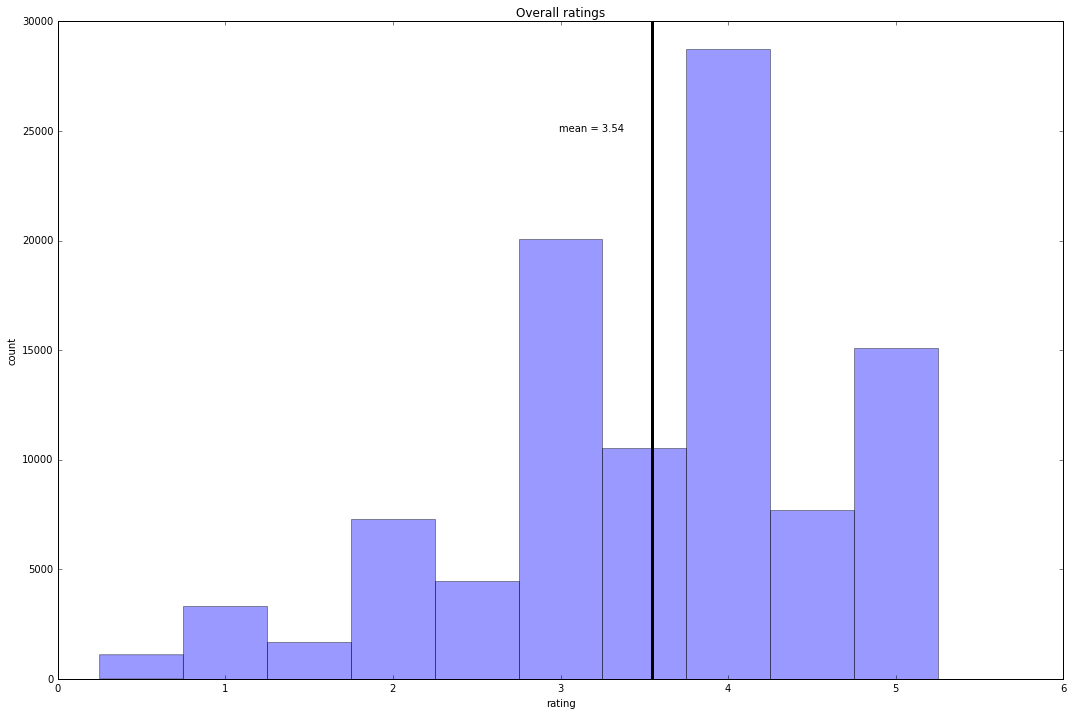

In [2]:
##Creating functions to import that data and return basic facts

Dataset = namedtuple('Dataset', ['ratings_df', 'movies_df'])


def read_data():
    ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
    movies_df = pd.read_csv('ml-latest-small/movies.csv')
    return Dataset(ratings_df, movies_df)


def get_fig_size():
    return 15, 10


def show_ratings_histogram(ratings):
    _, ax = plt.subplots(1, 1, figsize=get_fig_size())

    ax.hist(ratings, bins=np.arange(0.25, 5.5, step=0.5), alpha=0.4)

    ratings_mean = ratings.mean()

    ax.axvline(x=ratings_mean, linewidth=3, color='k')
    plt.text(ratings_mean - 0.55, 25000, 'mean = %.2f' % ratings_mean)

    ax.set_xlabel('rating')
    ax.set_ylabel('count')
    ax.set_title('Overall ratings')

    plt.tight_layout()
    plt.show()


def explore_basic_stats(dataset):
    ratings_df = dataset.ratings_df
    movies_df = dataset.movies_df

    user_ids = ratings_df['userId']
    ratings = ratings_df['rating']

    print 'How many ratings? {:,}'.format(len(ratings_df))

    user_id_counter = Counter(user_ids)

    print 'How many users?', len(user_id_counter)
    print 'How many movies? {:,}'.format(len(movies_df))

    ratings_counter = Counter(ratings)

    print 'How many unique ratings?', len(ratings_counter.keys())
    print 'Unique rating values:', sorted(ratings_counter.keys())
    print 'Overall ratings mean: {:.2f}'.format(ratings.mean())

    show_ratings_histogram(ratings)

    
dataset = read_data()

explore_basic_stats(dataset)

We can use the closest value to the mean ("3.5") as our simplest (naive) baseline prediction.

Analysis of dataset here.

# Part 2 - Continued Analysis

In this part, we'll specifically explore:

1. The number of ratings submitted per user
2. The mean of user ratings (x/5.0, for instance)
3. The number of ratings per movie
4. ...

The maximum number of ratings per user: 2391
The mean number of ratings per user: 149.04
The minimum number of ratings per user: 20


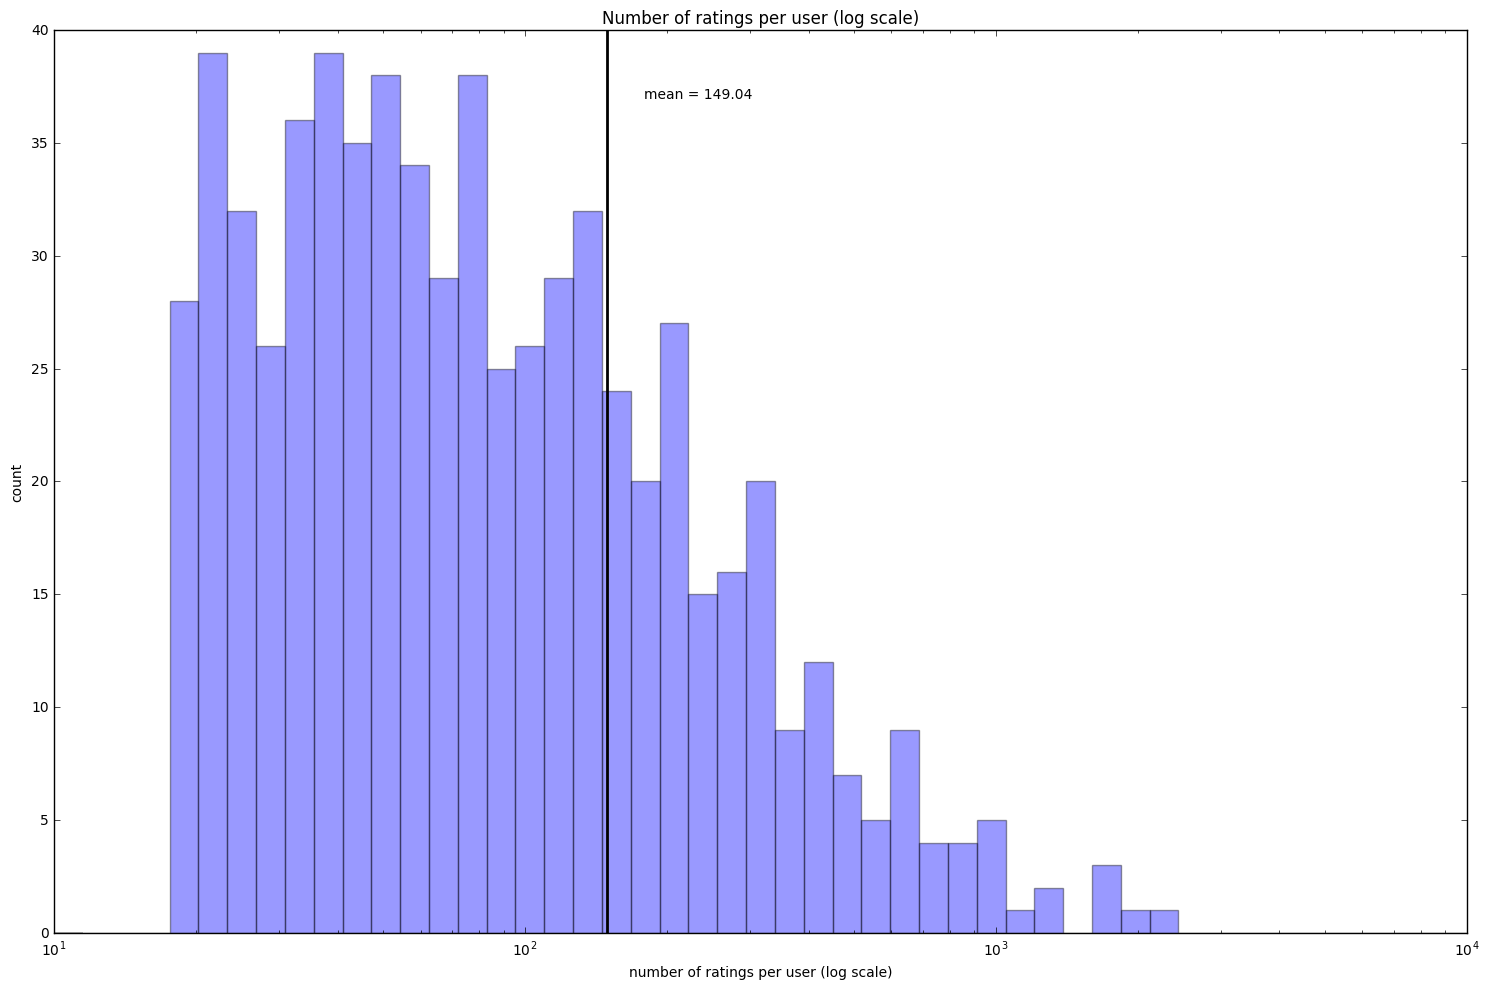

In [15]:
def explore_num_ratings_per_user(dataset):
    ratings_df = dataset.ratings_df
    user_ids = ratings_df['userId']

    user_id_counter = Counter(user_ids)
    num_ratings_per_user = user_id_counter.values()

    mean = np.mean(num_ratings_per_user)
    print 'The maximum number of ratings per user: %.0f' % np.max(num_ratings_per_user)
    print 'The mean number of ratings per user: %.2f' % mean
    print 'The minimum number of ratings per user: %.0f' % np.min(num_ratings_per_user)

    _, ax = plt.subplots(1, 1, figsize=get_fig_size())

    ax.hist(num_ratings_per_user, bins=np.logspace(1, 4, num=50), alpha=0.4)

    ax.axvline(x=mean, linewidth=2, color='k')
    plt.text(mean + 30, 37, 'mean = %.2f' % mean)

    ax.set_xscale('log')
    ax.set_xlabel('number of ratings per user (log scale)')
    ax.set_ylabel('count')
    ax.set_title('Number of ratings per user (log scale)')

    plt.tight_layout()
    plt.show()

    
explore_num_ratings_per_user(dataset)

Analysis here.

The maximum user mean rating: 4.95
The mean user mean rating: 3.66
The minimum user mean rating: 1.33


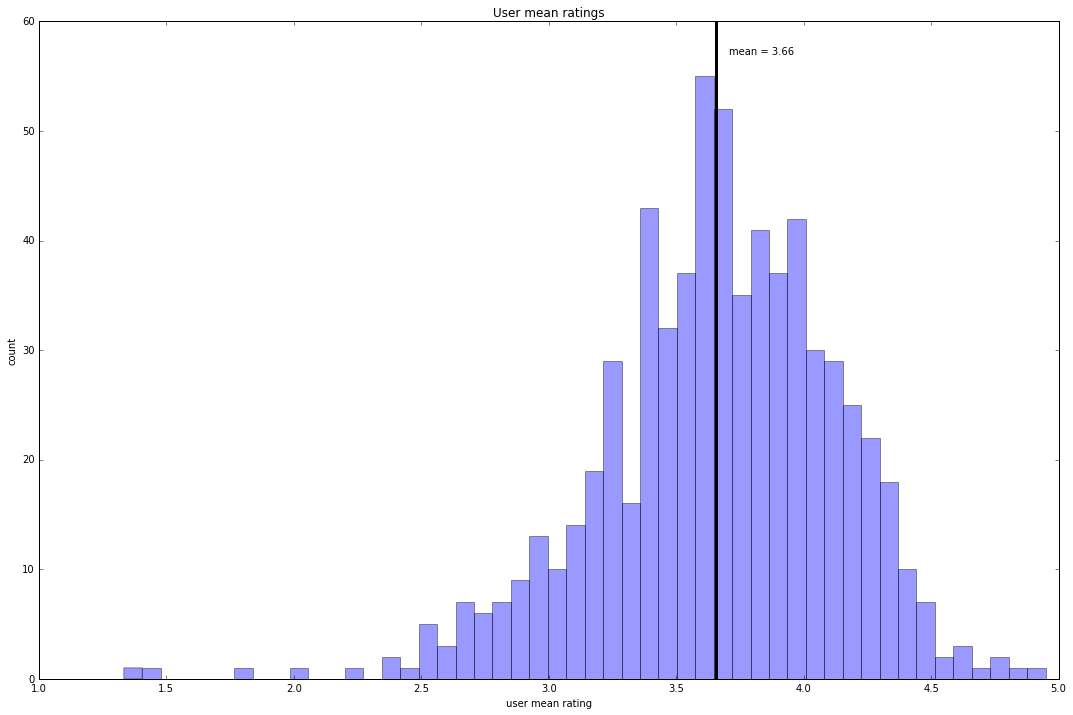

In [4]:
def explore_user_mean_ratings(dataset):
    ratings_df = dataset.ratings_df

    user_ratings = ratings_df.groupby('userId')['rating'].mean()

    print 'The maximum user mean rating: %.2f' % user_ratings.max()
    user_ratings_mean = user_ratings.mean()
    print 'The mean user mean rating: %.2f' % user_ratings_mean
    print 'The minimum user mean rating: %.2f' % user_ratings.min()

    _, ax = plt.subplots(1, 1, figsize=get_fig_size())

    ax.hist(user_ratings, bins=50, alpha=0.4)

    ax.axvline(x=user_ratings_mean, linewidth=3, color='k')
    plt.text(user_ratings_mean + 0.05, 57, 'mean = %.2f' % user_ratings_mean)

    ax.set_xlabel('user mean rating')
    ax.set_ylabel('count')
    ax.set_title('User mean ratings')

    plt.tight_layout()
    plt.show()

    
explore_user_mean_ratings(dataset)

Analysis here.

The maximum number of ratings per movie: 341
The mean number of ratings per movie: 11.03
The minimum number of ratings per movie: 1
Number of movies with one rating: 3,063
Number of movies with two ratings: 1,202


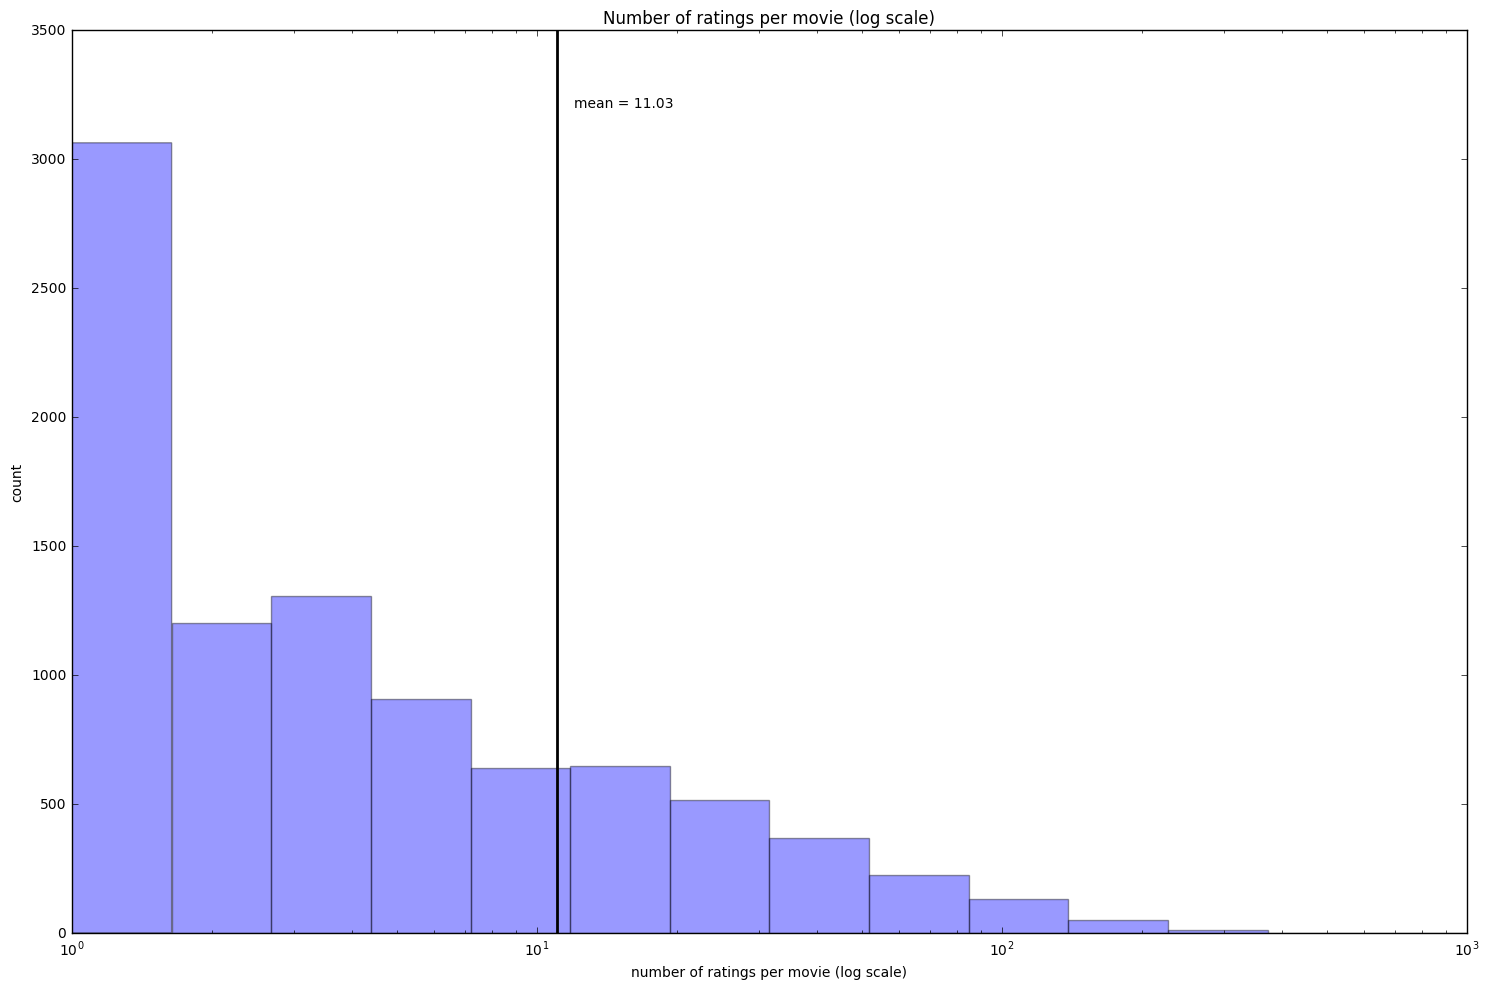

In [16]:
def explore_num_ratings_per_movie(dataset):
    ratings_df = dataset.ratings_df
    movie_ids = ratings_df['movieId']

    movie_id_counter = Counter(movie_ids)
    num_ratings_per_movie = movie_id_counter.values()

    mean = np.mean(num_ratings_per_movie)
    print 'The maximum number of ratings per movie: %.0f' % np.max(num_ratings_per_movie)
    print 'The mean number of ratings per movie: %.2f' % mean
    print 'The minimum number of ratings per movie: %.0f' % np.min(num_ratings_per_movie)

    num_ratings_per_movie_counter = Counter(num_ratings_per_movie)

    print 'Number of movies with one rating: {:,}'.format(num_ratings_per_movie_counter[1])
    print 'Number of movies with two ratings: {:,}'.format(num_ratings_per_movie_counter[2])

    _, ax = plt.subplots(1, 1, figsize=get_fig_size())

    ax.hist(num_ratings_per_movie, bins=np.logspace(0.0, 3.0, num=15), alpha=0.4)

    ax.axvline(x=mean, linewidth=2, color='k')
    plt.text(mean + 1, 3200, 'mean = %.2f' % mean)

    ax.set_xscale('log')
    ax.set_xlabel('number of ratings per movie (log scale)')
    ax.set_ylabel('count')
    ax.set_title('Number of ratings per movie (log scale)')

    plt.tight_layout()
    plt.show()

    
explore_num_ratings_per_movie(dataset)

Here we can notice that the majority of the movies don't have many ratings. About the third of the movies (3,063) has only one rating. We could try to cluster the movies into larger groups (e.g. by genre).

Analysis here.

The maximum movie mean rating: 5.00
The mean movie mean rating: 3.29
The minimum movie mean rating: 0.50


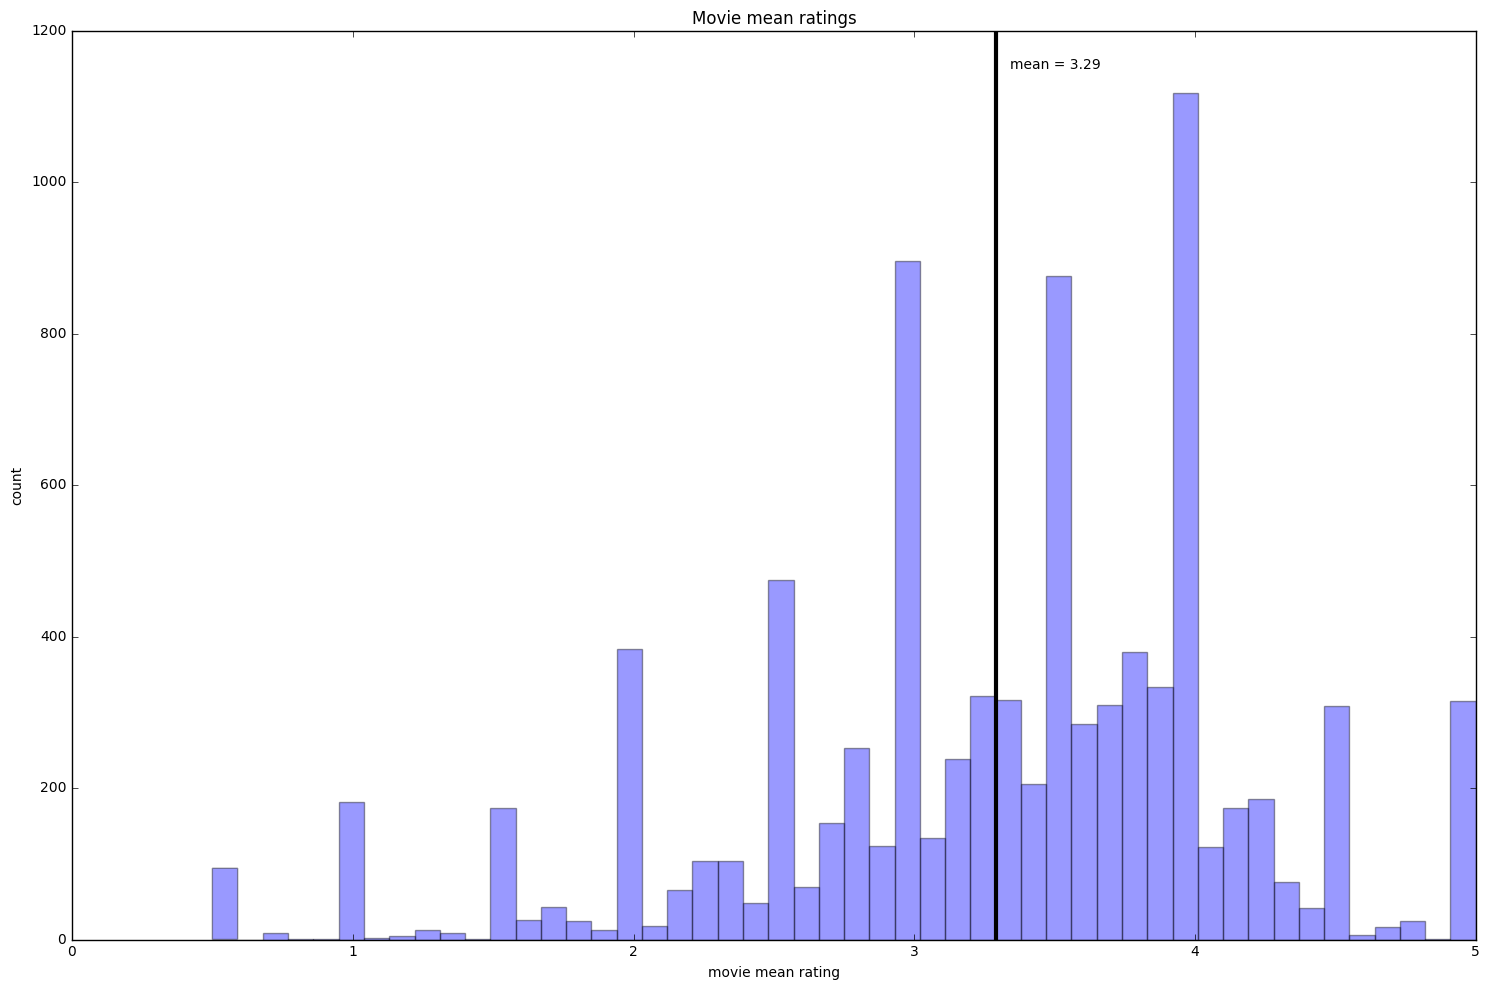

In [11]:
def explore_movie_mean_ratings(dataset):
    ratings_df = dataset.ratings_df

    movie_ratings = ratings_df.groupby('movieId')['rating']

    movie_mean_ratings = movie_ratings.mean()

    print 'The maximum movie mean rating: %.2f' % movie_mean_ratings.max()
    movie_ratings_mean = movie_mean_ratings.mean()
    print 'The mean movie mean rating: %.2f' % movie_ratings_mean
    print 'The minimum movie mean rating: %.2f' % movie_mean_ratings.min()

    _, ax = plt.subplots(1, 1, figsize=get_fig_size())

    ax.hist(movie_mean_ratings, bins=50, alpha=0.4)

    ax.axvline(x=movie_ratings_mean, linewidth=3, color='k')
    plt.text(movie_ratings_mean + 0.05, 1150, 'mean = %.2f' % movie_ratings_mean)

    ax.set_xlabel('movie mean rating')
    ax.set_ylabel('count')
    ax.set_title('Movie mean ratings')

    plt.tight_layout()
    plt.show()

    
explore_movie_mean_ratings(dataset)

We can notice the spikes for 0.5, 1.0, 2.0, etc values. It's because we have a lot of movies with just one rating.

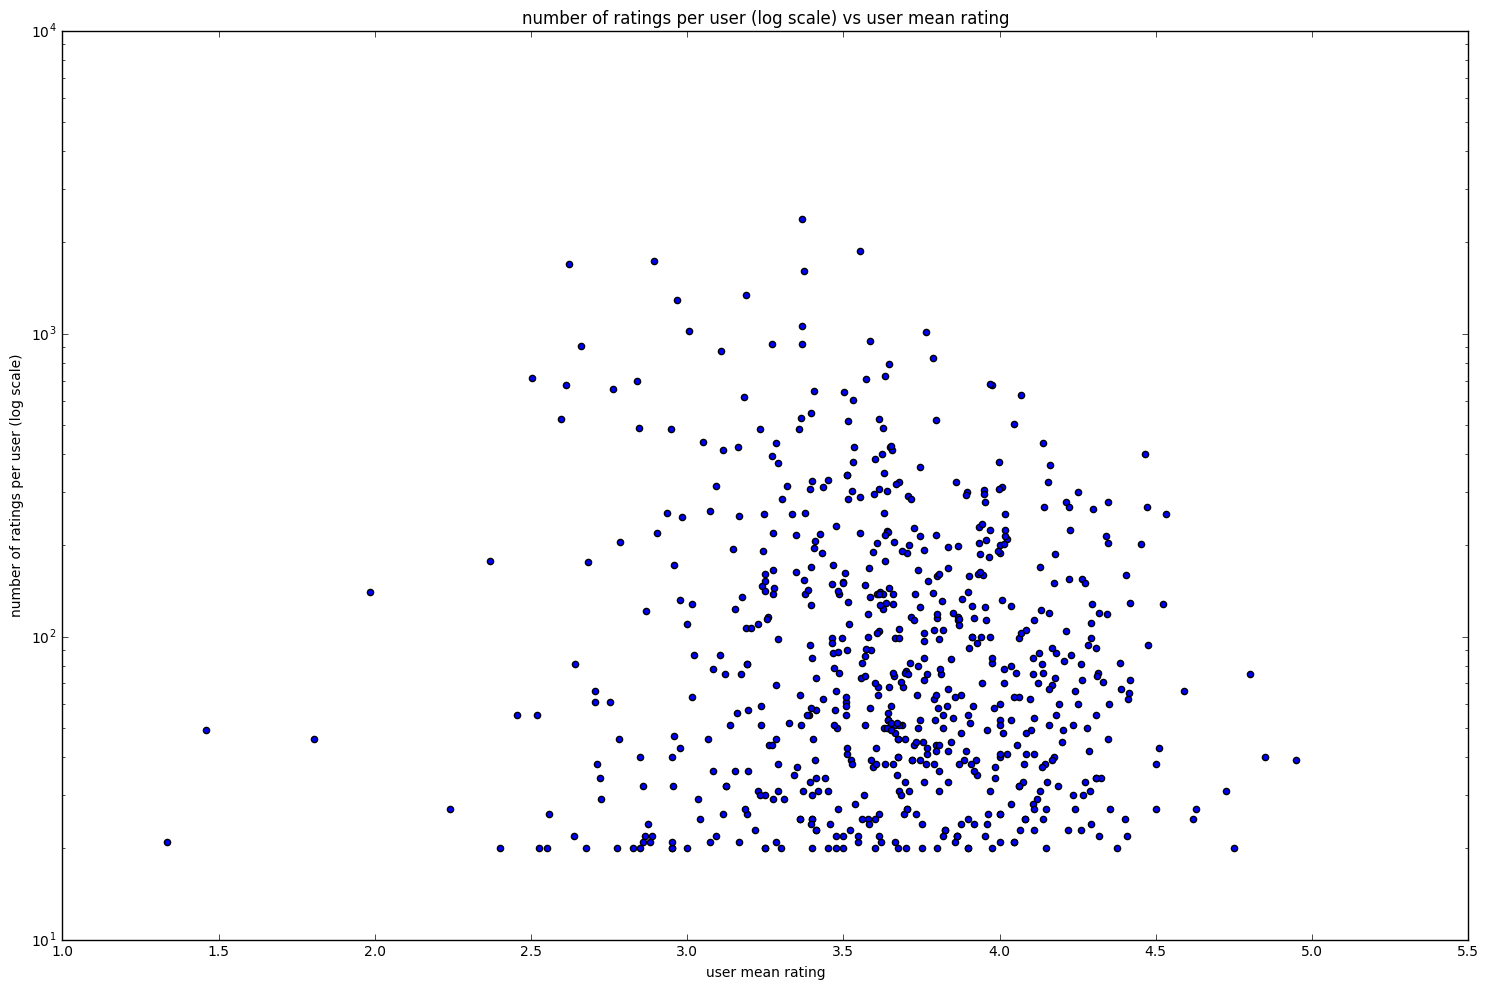

In [17]:
def explore_user_num_ratings_vs_mean_rating(dataset):
    ratings_df = dataset.ratings_df
    user_ratings = ratings_df.groupby('userId')['rating']

    user_agg = user_ratings.agg({'mean_rating': np.mean, 'count': 'count'})

    _, ax = plt.subplots(1, 1, figsize=get_fig_size())

    ax.scatter(user_agg['mean_rating'], user_agg['count'])

    ax.set_yscale('log')
    ax.set_xlabel('user mean rating')
    ax.set_ylabel('number of ratings per user (log scale)')
    ax.set_title('number of ratings per user (log scale) vs user mean rating')

    plt.tight_layout()
    plt.show()

    
explore_user_num_ratings_vs_mean_rating(dataset)

We used a log scale for numer of ratings to get less skewed distribution.

We can see that the more ratings we have for a user, the closer they get to the "middle" area (3.0-3.5).